# Exercises from Chap 6 


## Set-Up

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# import numpy as np

earthquakes = pd.read_csv('data/earthquakes.csv')

fb          = pd.read_csv('data/fb_stock_prices_2018.csv'
                , index_col = 'date'
                , parse_dates = True
                )

covid_df    = pd.read_csv('data/covid19_cases.csv'
                          ).assign(
                          date=lambda x: pd.to_datetime(x['dateRep'], format='%d/%m/%Y')
                          ).set_index('date')


# covid_df.info()
# covid_df.head(10)
# fb.info()
# fb.head(10)

## Q1

(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

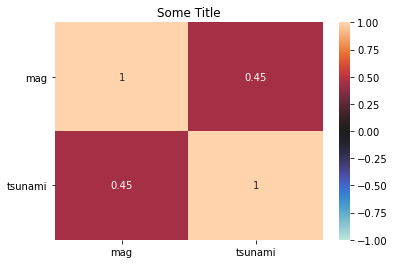

In [83]:
# earthquakes.query('magType == "mb"')
rows = earthquakes['magType'] == 'mb'

ax = sns.heatmap(
    earthquakes.loc[rows, ['mag', 'tsunami']]
    .corr()
    , annot=True, center=0, vmin=-1, vmax=1
    )
plt.title(f'Some Title')
plt.yticks(rotation=0)


# earthquakes[rows]

## Q2

           volume     close
0.25   17828394.0  157.9150
0.75   30313840.0  185.2700
iqr    12485446.0   27.3550
Q      18728169.0   41.0325
lower   -899775.0  116.8825
upper  49042009.0  226.3025


Text(0.5, 0.98, 'Facebook Volume Traded and Some Other Stuff for Ex2')

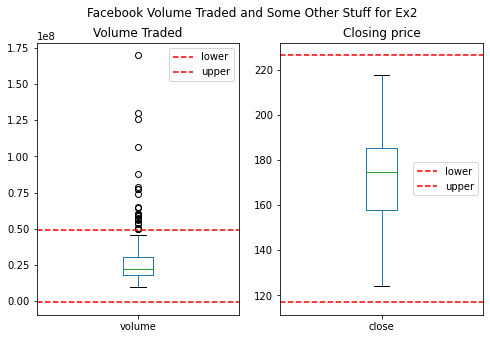

In [84]:
columns                     = ['volume', 'close']
titles                      = ['Volume Traded', 'Closing price']
subset_df                   = fb[columns]

quantiles                   = subset_df.quantile([0.25,0.75])
quantiles.loc['iqr',:]      = quantiles.loc[0.75,:] - quantiles.loc[0.25,:]
# quantiles.loc['Q',:]        = 1.5 * (quantiles.loc[0.75,:] - quantiles.loc[0.25,:])
quantiles.loc['Q',:]        = 1.5 * quantiles.loc['iqr',:]
quantiles.loc['lower',:]    = quantiles.loc[0.25,:] - quantiles.loc['Q',:]  
quantiles.loc['upper',:]    = quantiles.loc[0.75,:] + quantiles.loc['Q',:]  
print(quantiles)

axes = subset_df.plot(
        kind = 'box'
        , subplots = True
        , figsize=(8, 5)
        )

for ax, col, title in zip(axes, columns, titles):
    for bound in ['lower', 'upper']:
        ax.axhline(
              quantiles.loc[bound,col]
            , color='r'
            , linestyle='--'
            , label=bound
            )
    ax.set_title(title)
    ax.legend() 

plt.suptitle('Facebook Volume Traded and Some Other Stuff for Ex2')

## Q3

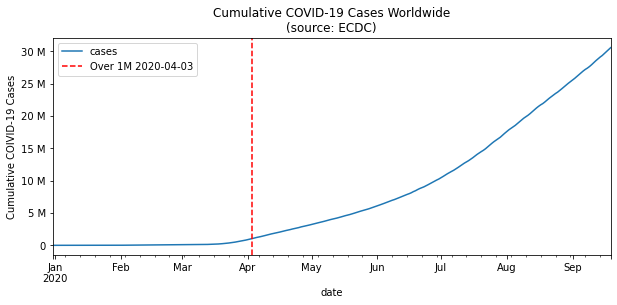

In [85]:
from matplotlib.ticker import EngFormatter

# Textbook version (creates a series)
# cumulative_cases_df = covid_df.groupby(pd.Grouper(freq = '1D')
#                     ).sum(
#                     )['cases'].cumsum(
#                     )

# # My version (creates a dataframe) 
cumulative_cases_df = covid_df.groupby(pd.Grouper(freq = '1D')
        ).agg({
        'cases': 'sum'    
        }).cumsum()
    
ax = cumulative_cases_df.plot(
          figsize = (10,4)
        , title = 'Cumulative COVID-19 Cases Worldwide\n(source: ECDC)'
        )

rows = cumulative_cases_df['cases'] >= 1e6
over_1M = cumulative_cases_df[rows].index[0]
ax.axvline(
        x = over_1M
        , color='r'
        , linestyle='--'
        , label=f'Over 1M {over_1M.strftime("%Y-%m-%d")}'
        )

plt.ylabel('Cumulative COIVID-19 Cases')
ax.legend()
ax.yaxis.set_major_formatter(EngFormatter())

## Q4

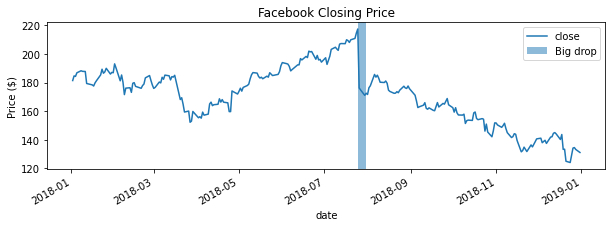

In [86]:
ax = fb['close'].plot(
    figsize = (10,3)    
    )

ax.axvspan(
      '2018-07-25'
    , '2018-07-31'
    , alpha = 0.5
    , label = 'Big drop'
    )

plt.title('Facebook Closing Price')
plt.ylabel('Price ($)')
plt.legend()

## Q5

Text(0, 0.5, 'Price ($)')

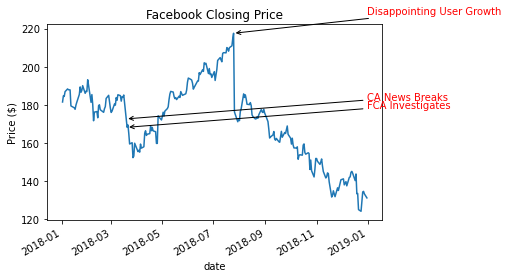

In [180]:
from datetime import timedelta

ax = fb['close'].plot()

points_of_note = [
      ('Disappointing User Growth', '2018-07-25')
    , ('CA News Breaks',            '2018-03-19')
    , ('FCA Investigates',          '2018-03-20')
    ]

for text, date in points_of_note:
    plt.annotate(
          text 
        , xy =      (date , fb.loc[date, 'close'])
        , xytext=   (fb.index[-1] , fb.loc[date, 'close']+10)
        , arrowprops=dict(arrowstyle='->')
        , color='red'
        , fontsize=10
        , fontweight='medium'
    )

plt.title('Facebook Closing Price')
plt.ylabel('Price ($)')

## Q6

,open,close
date,,
2018-01-02,177.68,181.42
2018-01-03,181.88,184.67
2018-01-04,184.90,184.33
2018-01-05,185.59,186.85
2018-01-08,187.20,188.28
...,...,...
2018-12-24,123.10,124.06
2018-12-26,126.00,134.18
2018-12-27,132.44,134.52


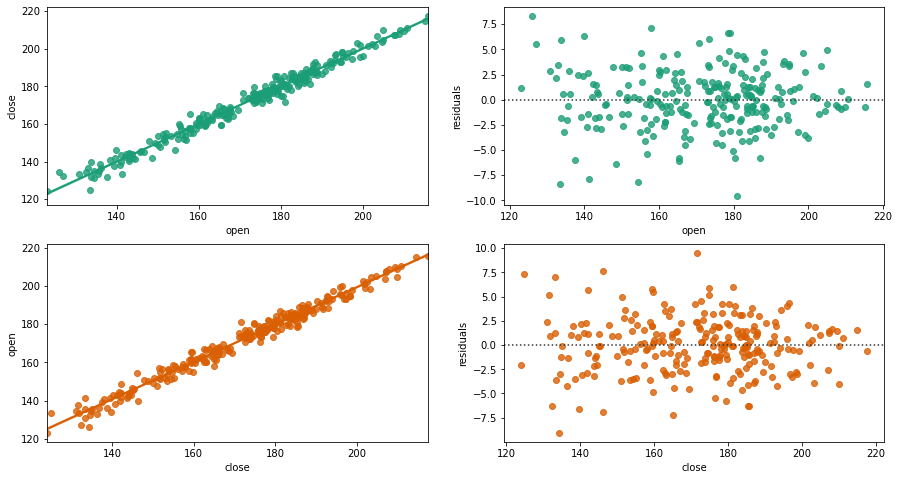

In [204]:
import itertools

def reg_resid_plots(data):
    """
    Using `seaborn`, plot the regression and residuals plots
    side-by-side for every permutation of 2 columns in the data.
    
    Parameters:
        - data: A `pandas.DataFrame`

    Returns:
        A matplotlib `Axes` object.
    """
    num_cols = data.shape[1]
    permutation_count = num_cols * (num_cols - 1)

    fig, ax = plt.subplots(permutation_count, 2, figsize=(15, 8))

    for (x, y), axes, color in zip(
          itertools.permutations(data.columns, 2)
        , ax
        # , itertools.cycle(['royalblue', 'darkorange'])
          , [cm.Dark2(i) for i in range(len(ax))]

    ):
        for subplot, func in zip(axes, (sns.regplot, sns.residplot)):
            func(x=x
                 , y=y
                 , data=data
                 , ax=subplot
                 , color=color
                 )

            if func == sns.residplot:
                # mark the residuals as such
                subplot.set_ylabel('residuals')
    return fig.axes

two_columns = fb[['open', 'close']]
reg_resid_plots(two_columns)
two_columns



# # Finding available colormaps
# from matplotlib import cm
# cm.datad.keys()
# Greens

## Q7

## Q8

## Q9

## Q10